## Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import librosa

from tqdm.auto import tqdm

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/YDS/Dacon/Covid_19'

## Hyperparameter Setting

In [ ]:
CFG = {
    'SR':22050,
    'N_MFCC':32, # MFCC 벡터를 추출할 개수
    'SEED':42
}

## Fixed Random-Seed

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-Processing 1

In [ ]:
train_df = pd.read_csv( base_path + '/train_data.csv')
test_df = pd.read_csv( base_path + '/test_data.csv')

In [ ]:
def get_mfcc_feature(df, data_type, save_path):
    # Data Folder path
    root_folder = base_path
    if os.path.exists(save_path):
        print(f'{save_path} is exist.')
        return
    features = []
    for uid in tqdm(df['id']):
        root_path = os.path.join(root_folder, data_type)
        path = os.path.join(root_path, str(uid).zfill(5)+'.wav')

        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)
    
    # 기존의 자가진단 정보를 담은 데이터프레임에 추출된 오디오 Feature를 추가
    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1,CFG['N_MFCC']+1)])
    df = pd.concat([df, mfcc_df], axis=1)
    df.to_csv(save_path, index=False)
    print('Done.')

In [ ]:
get_mfcc_feature(train_df, 'train', base_path + '/train_mfcc_data.csv')
get_mfcc_feature(test_df, 'test',  base_path + '/test_mfcc_data.csv')

  0%|          | 0/3805 [00:00<?, ?it/s]

Done.


  0%|          | 0/5732 [00:00<?, ?it/s]

Done.


## Data Pre-Processing 2

In [ ]:
# wav 파일의 MFCC Feature와 상태정보를 합친 학습데이터를 불러옵니다.
train_df = pd.read_csv( base_path + '/train_mfcc_data.csv')

# 학습데이터를 모델의 input으로 들어갈 x와 label로 사용할 y로 분할
train_x = train_df.drop(columns=['id', 'covid19'])
train_y = train_df['covid19']

In [ ]:
def onehot_encoding(ohe, x):
    # 학습데이터로 부터 fit된 one-hot encoder (ohe)를 받아 transform 시켜주는 함수
    encoded = ohe.transform(x['gender'].values.reshape(-1,1))
    encoded_df = pd.DataFrame(encoded, columns=ohe.categories_[0])
    x = pd.concat([x.drop(columns=['gender']), encoded_df], axis=1)
    return x

In [ ]:
# 'gender' column의 경우 추가 전처리가 필요 -> OneHotEncoder 적용
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_x['gender'].values.reshape(-1,1))
train_x = onehot_encoding(ohe, train_x)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.33)

## Train

Saved model to disk


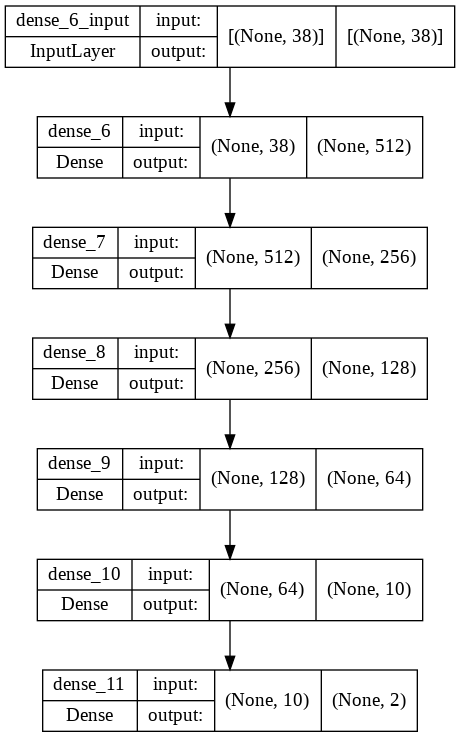

In [ ]:
from keras import models
from keras import layers
from keras.utils.vis_utils import plot_model

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(train_x.shape[1],)))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# plot model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=128)

In [ ]:
test_loss, test_acc = model.evaluate(X_val,y_val)

40/40 [==============================] - 0s 2ms/step - loss: 0.3334 - accuracy: 0.9108


In [ ]:
print('test_acc: ',test_acc)

test_acc:  0.9108280539512634


## Inference

In [ ]:
# 위의 학습데이터를 전처리한 과정과 동일하게 test data에도 적용
test_x = pd.read_csv(base_path + '/test_mfcc_data.csv')
test_x = test_x.drop(columns=['id'])
# Data Leakage에 유의하여 train data로만 학습된 ohe를 사용
test_x = onehot_encoding(ohe, test_x)

# Model 추론
preds = model.predict(test_x)

In [ ]:
preds

array([[8.08107316e-01, 1.91892654e-01],
       [8.71168077e-01, 1.28831968e-01],
       [8.84405017e-01, 1.15595050e-01],
       ...,
       [8.83081079e-01, 1.16918914e-01],
       [9.45400000e-01, 5.46000302e-02],
       [1.00000000e+00, 1.47424668e-08]], dtype=float32)

In [ ]:
y_classes = preds.argmax(axis=-1)
y_classes

array([0, 0, 0, ..., 0, 0, 0])

## Submission

In [ ]:
submission = pd.read_csv( base_path + '/sample_submission.csv')
submission['covid19'] = y_classes
submission.to_csv( base_path + '/saved/submit03.csv', index=False)